In [34]:
import h3
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from src.settings import *
from shapely.geometry import Polygon
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from src.tools.osmnx_utils import get_place_dir_name
from src.tools.h3_utils import get_resolution_buffered_suffix
from pathlib import Path
import plotly.express as px
import contextily as ctx
from keplergl import KeplerGl
from src.tools.aggregation import aggregate_hex
import random

tqdm.pandas()

In [35]:
CITIES = ["Wrocław", "Warszawa", "Kraków", "Poznań", "Gdańsk"]

In [36]:
df_road = pd.read_pickle(PROCESSED_DATA_DIR.joinpath("road_embedding.pkl.gz")).drop(columns=["h3_parent_id", "city", "resolution", "geometry", "cluster"])
df_transport = pd.read_pickle(PROCESSED_DATA_DIR.joinpath("public_transport_embedding.pkl.gz"))
hexagons = pd.read_pickle(PROCESSED_DATA_DIR.joinpath("hexagons.pkl.gz"))

In [37]:
df = hexagons.join(df_road)
df

,coordinates,parent,children,resolution,geometry,city,x_0,x_1,x_2,x_3,...,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29
h3_id,,,,,,,,,,,,,,,,,,,,,
891e2047227ffff,"(51.11809408699058, 17.099715574094844)",881e204723fffff,"{'8a1e2047225ffff', '8a1e20472257fff', '8a1e20...",9,"POLYGON ((17.09719 51.11886, 17.09722 51.11718...",Wrocław,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891e2041867ffff,"(51.05609756681724, 16.96809309035161)",881e204187fffff,"{'8a1e2041865ffff', '8a1e20418677fff', '8a1e20...",9,"POLYGON ((16.96557 51.05686, 16.96561 51.05518...",Wrocław,-5.378747,0.771603,-5.749843,1.119685,...,-2.462883,2.392268,-1.565160,-3.301478,0.917569,0.396109,-2.198904,-5.934234,-2.379401,-0.910382
891e20404dbffff,"(51.13500904528177, 16.90611076784273)",881e20404dfffff,"{'8a1e20404d9ffff', '8a1e20404d87fff', '8a1e20...",9,"POLYGON ((16.90358 51.13577, 16.90362 51.13409...",Wrocław,-0.191601,0.169056,-0.106877,-0.186770,...,-0.351646,-0.290235,-0.331685,-0.126381,0.075900,-0.418359,-0.180219,-0.422031,-0.133116,-0.515161
891e2040c33ffff,"(51.118325900443196, 17.021914098871278)",881e2040c3fffff,"{'8a1e2040c317fff', '8a1e2040c31ffff', '8a1e20...",9,"POLYGON ((17.01939 51.11909, 17.01942 51.11741...",Wrocław,-0.582006,1.272617,-3.804693,-1.456747,...,-0.698159,-1.021392,-0.529317,-2.175699,1.774402,-1.670312,-1.567980,-3.621682,-0.908762,-0.483289
891e20423d7ffff,"(51.1559504916846, 16.930728428682283)",881e20423dfffff,"{'8a1e20423d5ffff', '8a1e20423d6ffff', '8a1e20...",9,"POLYGON ((16.92820 51.15671, 16.92824 51.15503...",Wrocław,-0.336837,1.199190,-0.641221,-0.668527,...,-0.663605,-0.074363,-0.991075,-0.123962,1.112066,-0.831711,-0.230537,-0.427219,-0.588992,-0.546942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891f5104d97ffff,"(53.10625412901586, 23.10834881682837)",881f5104d9fffff,"{'8a1f5104d95ffff', '8a1f5104d947fff', '8a1f51...",9,"POLYGON ((23.10581 53.10713, 23.10569 53.10549...",Białystok,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891f5106913ffff,"(53.13326960870053, 23.107623699335438)",881f510691fffff,"{'8a1f51069117fff', '8a1f5106910ffff', '8a1f51...",9,"POLYGON ((23.10508 53.13414, 23.10497 53.13251...",Białystok,2.644778,2.481965,-10.605491,-8.179556,...,-8.226970,-2.925801,-3.218335,-7.245696,-0.087491,-10.225742,-1.871821,1.051573,0.324489,-6.181804
891f51a992fffff,"(53.15828258869769, 23.20057411517453)",881f51a993fffff,"{'8a1f51a992d7fff', '8a1f51a992dffff', '8a1f51...",9,"POLYGON ((23.19803 53.15916, 23.19791 53.15752...",Białystok,-1.089414,0.460215,-1.909310,-2.270251,...,-1.819012,0.438423,-0.245835,-0.249843,2.321965,-1.860974,-0.581521,-0.273016,-1.039297,-0.171614


In [38]:
df_full = df.reset_index().merge(df_transport, how="left", left_on="parent", right_on="hex_id").set_index("h3_id")
df_full = df_full[df_full["city"].isin(CITIES)]
df_full

,coordinates,parent,children,resolution,geometry,city,x_0,x_1,x_2,x_3,...,y_54,y_55,y_56,y_57,y_58,y_59,y_60,y_61,y_62,y_63
h3_id,,,,,,,,,,,,,,,,,,,,,
891e2047227ffff,"(51.11809408699058, 17.099715574094844)",881e204723fffff,"{'8a1e2047225ffff', '8a1e20472257fff', '8a1e20...",9,"POLYGON ((17.09719 51.11886, 17.09722 51.11718...",Wrocław,NaN,NaN,NaN,NaN,...,0.164515,-0.165083,-0.044243,-0.048513,0.316388,-0.061440,0.044145,0.116675,-0.163242,0.142304
891e2041867ffff,"(51.05609756681724, 16.96809309035161)",881e204187fffff,"{'8a1e2041865ffff', '8a1e20418677fff', '8a1e20...",9,"POLYGON ((16.96557 51.05686, 16.96561 51.05518...",Wrocław,-5.378747,0.771603,-5.749843,1.119685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891e20404dbffff,"(51.13500904528177, 16.90611076784273)",881e20404dfffff,"{'8a1e20404d9ffff', '8a1e20404d87fff', '8a1e20...",9,"POLYGON ((16.90358 51.13577, 16.90362 51.13409...",Wrocław,-0.191601,0.169056,-0.106877,-0.186770,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891e2040c33ffff,"(51.118325900443196, 17.021914098871278)",881e2040c3fffff,"{'8a1e2040c317fff', '8a1e2040c31ffff', '8a1e20...",9,"POLYGON ((17.01939 51.11909, 17.01942 51.11741...",Wrocław,-0.582006,1.272617,-3.804693,-1.456747,...,0.158786,-0.260391,-0.088387,-0.212154,0.524443,-0.172886,-0.012632,0.239300,-0.097142,0.281317
891e20423d7ffff,"(51.1559504916846, 16.930728428682283)",881e20423dfffff,"{'8a1e20423d5ffff', '8a1e20423d6ffff', '8a1e20...",9,"POLYGON ((16.92820 51.15671, 16.92824 51.15503...",Wrocław,-0.336837,1.199190,-0.641221,-0.668527,...,0.158519,-0.138550,-0.024573,-0.019315,0.254352,-0.032836,0.053037,0.103216,-0.168644,0.100271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891f09b622bffff,"(54.328197614010215, 18.90502779854358)",881f09b623fffff,"{'8a1f09b6229ffff', '8a1f09b6228ffff', '8a1f09...",9,"POLYGON ((18.90239 54.32896, 18.90238 54.32736...",Gdańsk,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891f0986c2bffff,"(54.338026397126676, 18.479803392333917)",881f0986c3fffff,"{'8a1f0986c2a7fff', '8a1f0986c2affff', '8a1f09...",9,"POLYGON ((18.47716 54.33878, 18.47716 54.33718...",Gdańsk,0.047635,0.615774,-0.259231,-0.403044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891f09b33a3ffff,"(54.29948167807119, 18.609156172390033)",881f09b33bfffff,"{'8a1f09b33a27fff', '8a1f09b33a0ffff', '8a1f09...",9,"POLYGON ((18.60652 54.30024, 18.60652 54.29864...",Gdańsk,-2.069658,2.471495,-3.305132,-2.958063,...,0.161458,-0.116991,-0.028942,-0.001502,0.221374,0.003116,0.056927,0.098958,-0.176755,0.080926


In [39]:
embedding = df_full.drop(columns=["coordinates", "parent", "children", "resolution", "geometry", "city"])
embedding

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_54,y_55,y_56,y_57,y_58,y_59,y_60,y_61,y_62,y_63
h3_id,,,,,,,,,,,,,,,,,,,,,
891e2047227ffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.164515,-0.165083,-0.044243,-0.048513,0.316388,-0.061440,0.044145,0.116675,-0.163242,0.142304
891e2041867ffff,-5.378747,0.771603,-5.749843,1.119685,0.665263,-11.331374,3.179559,-1.485957,-0.268744,2.034375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891e20404dbffff,-0.191601,0.169056,-0.106877,-0.186770,-0.165082,-1.016273,0.643773,0.267196,0.045801,-0.072752,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891e2040c33ffff,-0.582006,1.272617,-3.804693,-1.456747,-1.619986,-4.069328,2.944317,-0.548824,0.143232,3.027559,...,0.158786,-0.260391,-0.088387,-0.212154,0.524443,-0.172886,-0.012632,0.239300,-0.097142,0.281317
891e20423d7ffff,-0.336837,1.199190,-0.641221,-0.668527,-0.484690,-1.996236,0.930828,-0.143680,-0.103833,-0.120156,...,0.158519,-0.138550,-0.024573,-0.019315,0.254352,-0.032836,0.053037,0.103216,-0.168644,0.100271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891f09b622bffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891f0986c2bffff,0.047635,0.615774,-0.259231,-0.403044,-0.082230,-0.892945,0.250725,-0.332264,0.082837,0.469698,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891f09b33a3ffff,-2.069658,2.471495,-3.305132,-2.958063,-2.325633,-2.446155,-1.195632,-1.843227,-0.881343,1.544649,...,0.161458,-0.116991,-0.028942,-0.001502,0.221374,0.003116,0.056927,0.098958,-0.176755,0.080926


In [40]:
# 🤮🤮🤮🤮🤮🤮🤮🤮🤮 FIXME 🤮🤮🤮🤮🤮🤮🤮🤮🤮

transport_zeros_embedding = np.array([-0.1442179 , -0.16091143, -0.09551783, -0.01457933,  0.05733945,
       -0.10733436,  0.02091195,  0.20901783, -0.11247121,  0.11951638,
       -0.25575215,  0.05458846, -0.06455792, -0.04703282, -0.01654218,
        0.13232772,  0.04793482, -0.01963536,  0.01833065,  0.00817847,
       -0.09989935, -0.09808404,  0.03073937,  0.10224744, -0.06014029,
        0.02100451, -0.02835732,  0.04284903, -0.00248026,  0.18758623,
        0.00644384,  0.00083099,  0.15321097, -0.03004447, -0.07283027,
       -0.03449459,  0.14458147, -0.00605578,  0.03377878, -0.01580629,
       -0.02128212,  0.04459944, -0.26601887,  0.01274732, -0.05414183,
        0.00386066,  0.01285186, -0.14623877, -0.04911132,  0.00903231,
        0.05994765,  0.03791163, -0.07504247, -0.04053234,  0.1555372 ,
       -0.07552458, -0.0126978 ,  0.01514858,  0.17848766,  0.03136923,
        0.07247312,  0.10736874, -0.19989811,  0.04694967], dtype=np.float32)

road_zeros_embedding = np.array([ 0.0555021 ,  0.04344444,  0.00668686, -0.19877295,  0.00940313,
       -0.349162  ,  0.1700421 , -0.02272386,  0.11920231,  0.3097641 ,
       -0.13769932,  0.25137907,  0.03780234,  0.22747263, -0.31611007,
       -0.15458846,  0.08668634,  0.08182073, -0.05827295,  0.18888496,
       -0.02332959, -0.24750751, -0.00365096, -0.2012625 , -0.05933614,
       -0.10311864, -0.23276374, -0.12063856, -0.01470058,  0.00615425],
      dtype=np.float32)

for i in range(64):
    embedding.loc[embedding[f'y_{i}'].isna(), f'y_{i}'] = transport_zeros_embedding[i]
for i in range(30):
    embedding.loc[embedding[f'x_{i}'].isna(), f'x_{i}'] = road_zeros_embedding[i]

embedding

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_54,y_55,y_56,y_57,y_58,y_59,y_60,y_61,y_62,y_63
h3_id,,,,,,,,,,,,,,,,,,,,,
891e2047227ffff,0.055502,0.043444,0.006687,-0.198773,0.009403,-0.349162,0.170042,-0.022724,0.119202,0.309764,...,0.164515,-0.165083,-0.044243,-0.048513,0.316388,-0.061440,0.044145,0.116675,-0.163242,0.142304
891e2041867ffff,-5.378747,0.771603,-5.749843,1.119685,0.665263,-11.331374,3.179559,-1.485957,-0.268744,2.034375,...,0.155537,-0.075525,-0.012698,0.015149,0.178488,0.031369,0.072473,0.107369,-0.199898,0.046950
891e20404dbffff,-0.191601,0.169056,-0.106877,-0.186770,-0.165082,-1.016273,0.643773,0.267196,0.045801,-0.072752,...,0.155537,-0.075525,-0.012698,0.015149,0.178488,0.031369,0.072473,0.107369,-0.199898,0.046950
891e2040c33ffff,-0.582006,1.272617,-3.804693,-1.456747,-1.619986,-4.069328,2.944317,-0.548824,0.143232,3.027559,...,0.158786,-0.260391,-0.088387,-0.212154,0.524443,-0.172886,-0.012632,0.239300,-0.097142,0.281317
891e20423d7ffff,-0.336837,1.199190,-0.641221,-0.668527,-0.484690,-1.996236,0.930828,-0.143680,-0.103833,-0.120156,...,0.158519,-0.138550,-0.024573,-0.019315,0.254352,-0.032836,0.053037,0.103216,-0.168644,0.100271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891f09b622bffff,0.055502,0.043444,0.006687,-0.198773,0.009403,-0.349162,0.170042,-0.022724,0.119202,0.309764,...,0.155537,-0.075525,-0.012698,0.015149,0.178488,0.031369,0.072473,0.107369,-0.199898,0.046950
891f0986c2bffff,0.047635,0.615774,-0.259231,-0.403044,-0.082230,-0.892945,0.250725,-0.332264,0.082837,0.469698,...,0.155537,-0.075525,-0.012698,0.015149,0.178488,0.031369,0.072473,0.107369,-0.199898,0.046950
891f09b33a3ffff,-2.069658,2.471495,-3.305132,-2.958063,-2.325633,-2.446155,-1.195632,-1.843227,-0.881343,1.544649,...,0.161458,-0.116991,-0.028942,-0.001502,0.221374,0.003116,0.056927,0.098958,-0.176755,0.080926


In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embedding = pd.DataFrame(scaler.fit_transform(embedding), index=embedding.index, columns=embedding.columns)
embedding

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_54,y_55,y_56,y_57,y_58,y_59,y_60,y_61,y_62,y_63
h3_id,,,,,,,,,,,,,,,,,,,,,
891e2047227ffff,0.542117,-0.514654,0.693679,0.664160,0.587295,0.685693,-0.350693,0.473523,0.099620,-0.481492,...,0.608094,-0.211633,-0.317485,0.169282,0.052238,-0.047209,0.036481,-0.369193,-0.074342,0.067933
891e2041867ffff,-4.011417,-0.154123,-1.944644,1.436568,1.010988,-2.223995,1.264065,-0.510852,-0.255622,0.358845,...,0.076893,0.930826,0.384417,0.657274,-0.759676,0.732950,0.841290,-0.451014,-0.864661,-0.794498
891e20404dbffff,0.335061,-0.452461,0.641631,0.671191,0.474576,0.508945,-0.096513,0.668564,0.032406,-0.667877,...,0.076893,0.930826,0.384417,0.657274,-0.759676,0.732950,0.841290,-0.451014,-0.864661,-0.794498
891e2040c33ffff,0.007928,0.093942,-1.053146,-0.072815,-0.465310,-0.299949,1.137845,0.119595,0.121624,0.842786,...,0.269112,-1.427439,-1.299717,-1.085103,1.277195,-0.984039,-1.576603,0.708889,1.350772,1.325240
891e20423d7ffff,0.213363,0.057587,0.396731,0.388958,0.268105,0.249308,0.057507,0.392151,-0.104613,-0.690975,...,0.253324,0.126834,0.120184,0.393098,-0.313009,0.193235,0.289090,-0.487525,-0.190823,-0.312230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891f09b622bffff,0.542117,-0.514654,0.693679,0.664160,0.587295,0.685693,-0.350693,0.473523,0.099620,-0.481492,...,0.076893,0.930826,0.384417,0.657274,-0.759676,0.732950,0.841290,-0.451014,-0.864661,-0.794498
891f0986c2bffff,0.535524,-0.231278,0.571804,0.544489,0.528099,0.541620,-0.307403,0.265283,0.066320,-0.403562,...,0.076893,0.930826,0.384417,0.657274,-0.759676,0.732950,0.841290,-0.451014,-0.864661,-0.794498
891f09b33a3ffff,-1.238623,0.687539,-0.824188,-0.952349,-0.921166,0.130104,-1.083446,-0.751202,-0.816578,0.120221,...,0.427184,0.401856,0.022962,0.529638,-0.507175,0.495450,0.399619,-0.524956,-0.365697,-0.487200


In [53]:
from sklearn.cluster import AgglomerativeClustering

agglomerative_clustering = AgglomerativeClustering(n_clusters=9, affinity="euclidean", linkage="ward")
df_full["cluster"] = pd.Series(agglomerative_clustering.fit_predict(embedding), index=df_full.index).astype("category")

<AxesSubplot:>

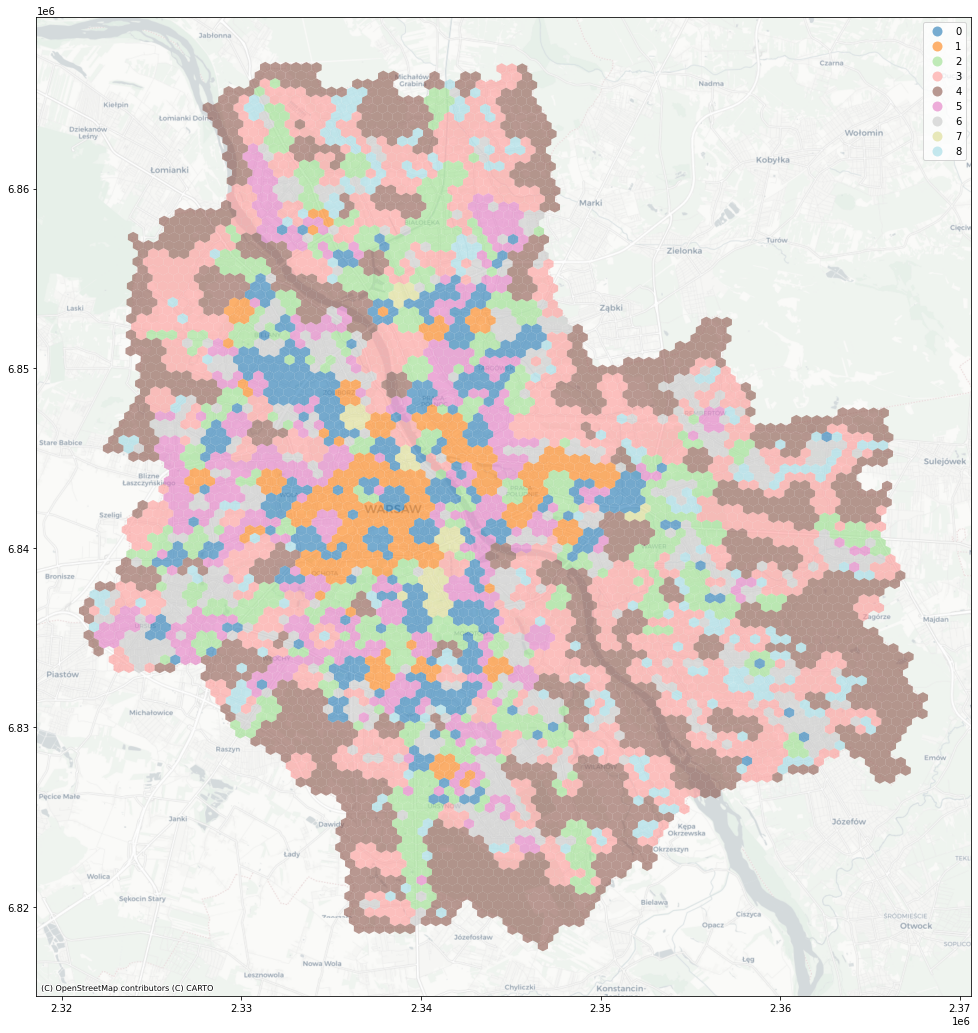

In [59]:
from src.tools.vis_utils import plot_hexagons_map

city = "Warszawa"
plot_hexagons_map(df_full[df_full["city"] == city], None, "cluster")

In [55]:
from src.tools.dim_reduction import reduce_umap
from src.tools.vis_utils import plot_clusters

ble = reduce_umap(embedding, n_components=2, n_neighbors=15, metric="cosine")[0]
ble["cluster"] = df_full["cluster"]
plot_clusters(ble)

In [56]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)
distances

array([[0.        , 0.        , 0.        , ..., 0.95369622, 0.95369622,
        0.95442914],
       [0.        , 4.16567904, 5.23309026, ..., 7.27594927, 7.38509982,
        7.42045882],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 1.15289488, 1.26605267, ..., 1.37713315, 1.49024706,
        1.56800643],
       [0.        , 2.20058297, 3.25447181, ..., 3.86573796, 3.89250541,
        3.99372659],
       [0.        , 0.53697262, 0.53697262, ..., 0.56169779, 0.56169779,
        0.56169779]])

In [60]:
indices

array([[ 1789,  2982,     0, ..., 10801,  9296, 12297],
       [    1, 12794,  1250, ...,  2861,  2394,  7189],
       [ 6255, 15000,  1790, ..., 12122,     2, 12273],
       ...,
       [17844,  8348, 10368, ...,  9506, 11969, 13051],
       [17845, 17072, 11102, ...,  2467, 14557, 15403],
       [17846, 12884, 13750, ..., 14668, 13320, 12052]], dtype=int64)

In [58]:
m = KeplerGl(data={"hexagons": df_full.copy()}, height=700)
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'hexagons':                                               coordinates           parent  \
h3_id…